# Libraries

In [2]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Functions

In [3]:
def load_lesion(les_file):
    with open(les_file, "rb") as f:
        coords = np.frombuffer(f.read(12), dtype='<u2').reshape((3,2), order='F')
        y_start, y_end = coords[0]
        x_start, x_end = coords[1]
        z_start, z_end = coords[2]

        # Tamaño en cada eje
        size = (y_end - y_start + 1,
                x_end - x_start + 1,
                z_end - z_start + 1)
        expected_size = np.prod(size)

        # Lee el resto como int8
        binary_data = f.read()
        actual_size = len(binary_data)
        if actual_size != expected_size:
            raise ValueError(
                f"Dimensiones inconsistentes: esperado {expected_size}, "
                f"pero se encontró {actual_size}"
            )

        mask = np.frombuffer(binary_data, dtype=np.int8).reshape(size)
    return coords, mask

In [4]:
def load_all_series_in_folder(patient_folder):
    images = {}
    reader = sitk.ImageSeriesReader()
    
    for root, dirs, files in os.walk(patient_folder):
        series_ids = reader.GetGDCMSeriesIDs(root)
        for s_id in series_ids:
            file_names = reader.GetGDCMSeriesFileNames(root, s_id)
            if not file_names:
                continue
            reader.SetFileNames(file_names)
            sitk_image = reader.Execute()
            images[s_id] = (sitk_image, file_names)
            
    return images

# Main

Coordenadas de la lesión (voxel indices):
  Y: 139..170
  X: 107..134
  Z: 23..29
mask_3d shape (z, y, x): (7, 32, 28)
Procesando serie: 1.3.6.1.4.1.14519.5.2.1.9203.4002.968176437755076605598557347150


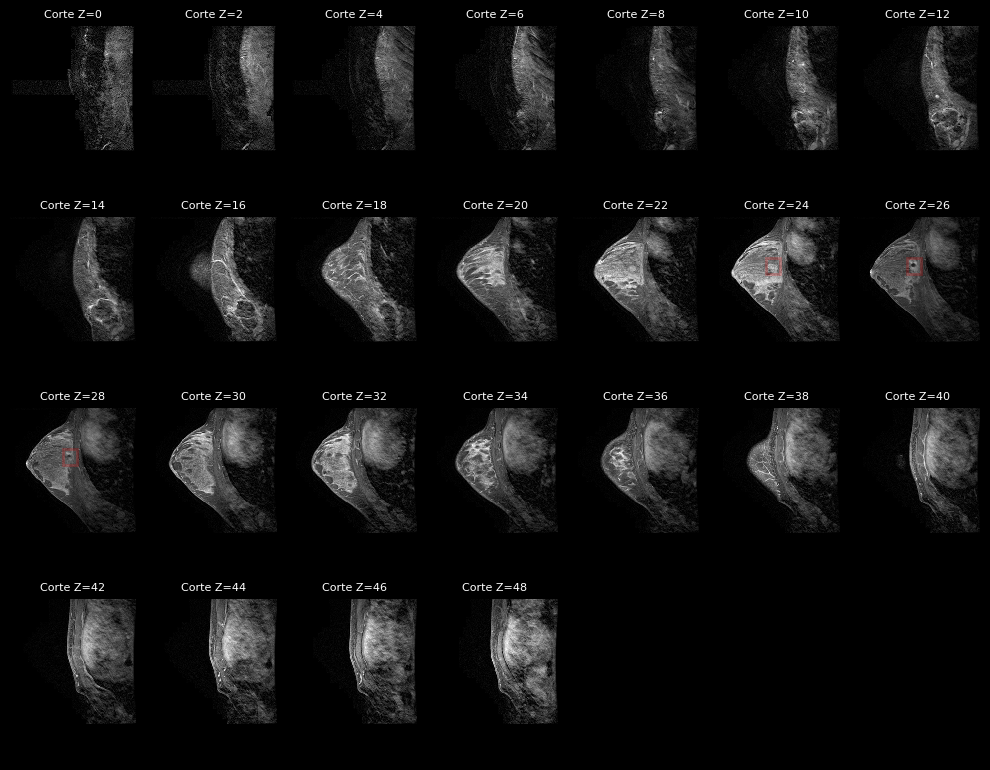

In [8]:
base_dir = "../../data/images/manifest-AmUKkZHx1564984923148296294/TCGA-BRCA/"
patient_folder = os.path.join(base_dir, "TCGA-AO-A03M", "03-15-2001-NA-NA-80891", "116.000000-Bind112517289..338-47150")

# Cargar la serie específica del paciente
all_series = load_all_series_in_folder(patient_folder)

# Archivo de lesión
les_file = "../../data/TCGA_Segmented_Lesions_UofC/TCGA-AO-A03M-1.les"
coords, mask = load_lesion(les_file)

# Extraer coordenadas de la lesión
y_start, y_end = coords[0]
x_start, x_end = coords[1]
z_start, z_end = coords[2]
print(f"Coordenadas de la lesión (voxel indices):")
print(f"  Y: {y_start}..{y_end}")
print(f"  X: {x_start}..{x_end}")
print(f"  Z: {z_start}..{z_end}")

# Transponer la máscara para alinearla con la convención [z, y, x]
mask_3d = np.transpose(mask, (2, 0, 1))
print(f"mask_3d shape (z, y, x): {mask_3d.shape}")

# Procesar la serie cargada
step = 2  # Variable que indica cada cuántos cortes mostrar
cols = 7  # Número de columnas en la figura

for s_id, (sitk_image, file_names) in all_series.items():
    print(f"Procesando serie: {s_id}")

    # Convertir la imagen a NumPy
    image_nda = sitk.GetArrayFromImage(sitk_image)
    (Z, Y, X) = image_nda.shape

    # Ajustar los índices para no salir del volumen
    z1 = max(0, z_start)
    z2 = min(Z - 1, z_end)
    y1 = max(0, y_start)
    y2 = min(Y - 1, y_end)
    x1 = max(0, x_start)
    x2 = min(X - 1, x_end)

    # Configurar la figura adaptando el número de filas
    slices = range(0, Z, step)
    rows = (len(slices) + cols - 1) // cols  # Calcular filas necesarias
    fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 2), facecolor='black')
    axes = axes.flatten()

    for idx, z_slice in enumerate(slices):
        # Extraer el plano 2D
        slice_2d = image_nda[z_slice].copy()

        # Visualizar el plano 2D
        ax = axes[idx]
        ax.imshow(
            slice_2d,
            cmap='gray',
            origin='lower',
            interpolation='nearest'
        )

        # Si el corte está dentro del rango de la lesión, dibujar el rectángulo
        if z1 <= z_slice <= z2:
            width = x2 - x1 + 1
            height = y2 - y1 + 1
            rect = patches.Rectangle(
                (x1, y1),        # esquina inferior-izquierda
                width,            # ancho
                height,           # alto
                linewidth=2,     # grosor del borde
                edgecolor='red', # color del borde
                facecolor='gray',# color de relleno
                alpha=0.2        # transparencia del relleno
            )
            ax.add_patch(rect)

        # Configurar título
        ax.set_title(f"Corte Z={z_slice}", fontsize=8, color='white')
        ax.axis('off')

    # Eliminar ejes sobrantes
    for ax in axes[len(slices):]:
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reducir la separación entre imágenes
    plt.tight_layout()
    plt.show()

    # Salir después de procesar una única serie
    break